<a href="https://colab.research.google.com/github/SpectraGbes/Spectragbes/blob/main/Predicted_vs_Actual_SPMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import yfinance as yf
import pandas as pd
import os
import requests
from bs4 import BeautifulSoup
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

def download_price_data(ticker="AAPL", period="5y", interval="1d"):
    data = yf.download(ticker, period=period, interval=interval)
    os.makedirs("data/price_data", exist_ok=True)
    save_path = f"data/price_data/{ticker}.csv"
    data.to_csv(save_path)
    print(f"[+] Saved price data → {save_path}")

if __name__ == "__main__":
    download_price_data("AAPL")

/tmp/ipython-input-1506262474.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed

[+] Saved price data → data/price_data/AAPL.csv


In [5]:
def fetch_finviz_news(ticker="AAPL"):
    url = f"https://finviz.com/quote.ashx?t={ticker}"
    html = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).text
    soup = BeautifulSoup(html, "html.parser")

    news = []
    rows = soup.find(id="news-table").find_all("tr")

    for row in rows:
        # Check if row.td and row.a exist before accessing their attributes
        if row.td and row.a:
            date_time = row.td.text.strip()
            headline = row.a.text.strip()
            news.append([date_time, headline])

    df = pd.DataFrame(news, columns=["datetime", "headline"])
    os.makedirs("data/news_data", exist_ok=True)
    save_path = f"data/news_data/{ticker}_news.csv"
    df.to_csv(save_path, index=False)
    print(f"[+] Saved news → {save_path}")

if __name__ == "__main__":
    fetch_finviz_news("AAPL")

[+] Saved news → data/news_data/AAPL_news.csv


In [7]:
import yfinance as yf
import pandas as pd
import os
import requests
from bs4 import BeautifulSoup
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from json.decoder import JSONDecodeError # Import JSONDecodeError

def download_price_data(ticker="AAPL", period="5y", interval="1d"):
    data = yf.download(ticker, period=period, interval=interval)
    os.makedirs("data/price_data", exist_ok=True)
    save_path = f"data/price_data/{ticker}.csv"
    data.to_csv(save_path)
    print(f"[+] Saved price data → {save_path}")

def fetch_finviz_news(ticker="AAPL"):
    url = f"https://finviz.com/quote.ashx?t={ticker}"
    html = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).text
    soup = BeautifulSoup(html, "html.parser")

    news = []
    rows = soup.find(id="news-table").find_all("tr")

    for row in rows:
        # Check if row.td and row.a exist before accessing their attributes
        if row.td and row.a:
            date_time = row.td.text.strip()
            headline = row.a.text.strip()
            news.append([date_time, headline])

    df = pd.DataFrame(news, columns=["datetime", "headline"])
    os.makedirs("data/news_data", exist_ok=True)
    save_path = f"data/news_data/{ticker}_news.csv"
    df.to_csv(save_path, index=False)
    print(f"[+] Saved news → {save_path}")

def fetch_pushshift(subreddit="wallstreetbets", limit=200):
    url = f"https://api.pullpush.io/reddit/search/submission/?subreddit={subreddit}&size={limit}"
    data = [] # Initialize data as empty list
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)
        json_response = response.json()
        data = json_response.get('data', []) # Safely get 'data' key, default to empty list if not found
        if not data:
            print(f"[-] No 'data' found in Pushshift API response for {subreddit}. Full response: {json_response}")
    except requests.exceptions.HTTPError as e:
        print(f"[-] HTTP Error {response.status_code} fetching data from Pushshift API for {subreddit}: {e}")
        print(f"[-] Response content: {response.text}")
    except JSONDecodeError as e:
        print(f"[-] JSON Decode Error fetching data from Pushshift API for {subreddit}: {e}")
        print(f"[-] Response content: {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"[-] General Request Error fetching data from Pushshift API for {subreddit}: {e}")

    df = pd.DataFrame([
        {
            "title": d.get("title"),
            "selftext": d.get("selftext"),
            "score": d.get("score"),
            "num_comments": d.get("num_comments"),
            "created_utc": d.get("created_utc")
        } for d in data
    ])

    os.makedirs("data/social_data", exist_ok=True)
    df.to_csv("data/social_data/reddit_pushshift.csv", index=False)
    print("[+] Saved Reddit data → data/social_data/reddit_pushshift.csv")

fetch_pushshift()

[-] HTTP Error 525 fetching data from Pushshift API for wallstreetbets: 525 Server Error: <none> for url: https://api.pullpush.io/reddit/search/submission/?subreddit=wallstreetbets&size=200
[-] Response content: <!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>

<title>pullpush.io | 525: SSL handshake failed</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />
</head>
<body>
<div id="cf-wrapper">
    <div id="cf-error-de

In [10]:
# ============================================================
# 1. TEXT CLEANING (News + Reddit)
# ============================================================

def clean_text(text):
    if pd.isna(text):
        return ""
    s = str(text).lower()
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"www.\S+", " ", s)
    s = re.sub(r"[$][a-z0-9_]+", " ", s)       # cashtags
    s = re.sub(r"@[a-z0-9_]+", " ", s)         # mentions
    s = re.sub(r"#[a-z0-9_]+", " ", s)         # hashtags
    s = re.sub(r"[^a-z0-9\s]", " ", s)         # punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s


# ============================================================
# 2. PRICE DATA PROCESSING
# ============================================================

def compute_indicators(df):
    df = df.copy()

    df["return"] = df["Close"].pct_change()
    df["log_return"] = np.log(df["Close"]).diff()

    # SMAs + EMAs
    for w in [5, 10, 20, 50, 100, 200]:
        df[f"sma_{w}"] = df["Close"].rolling(w).mean()
        df[f"ema_{w}"] = df["Close"].ewm(span=w, adjust=False).mean()

    # Volatility indicators
    for w in [5, 10, 20]:
        df[f"vol_{w}"] = df["return"].rolling(w).std() * np.sqrt(252)

    # RSI
    delta = df["Close"].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    roll_up = up.ewm(span=14).mean()
    roll_down = down.ewm(span=14).mean()
    rs = roll_up / (roll_down + 1e-9)
    df["rsi_14"] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = df["Close"].ewm(span=12).mean()
    ema26 = df["Close"].ewm(span=26).mean()
    df["macd"] = ema12 - ema26
    df["macd_signal"] = df["macd"].ewm(span=9).mean()
    df["macd_hist"] = df["macd"] - df["macd_signal"]

    # Bollinger Bands
    sma20 = df["Close"].rolling(20).mean()
    std20 = df["Close"].rolling(20).std()
    df["bb_upper"] = sma20 + (2 * std20)
    df["bb_lower"] = sma20 - (2 * std20)
    df["bb_bw"] = (df["bb_upper"] - df["bb_lower"]) / sma20

    # ATR
    high_low = (df["High"] - df["Low"]).abs()
    high_close = (df["High"] - df["Close"].shift(1)).abs()
    low_close = (df["Low"] - df["Close"].shift(1)).abs()
    df["atr_14"] = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1).rolling(14).mean()

    # Next-day target
    df["target_return_1d"] = df["Close"].shift(-1) / df["Close"] - 1
    df["target_up"] = (df["target_return_1d"] > 0).astype(int)

    return df


# ============================================================
# 3. NEWS PREPROCESSING
# ============================================================

def parse_news_datetime(x):
    x = str(x)

    if x.startswith("Today"):
        t = x.replace("Today", "").strip()
        today = datetime.today().date()
        return datetime.strptime(str(today) + " " + t, "%Y-%m-%d %I:%M%p")

    # Format: "07:51AM" → must assign PREVIOUS trading day
    if re.match(r"^\d{2}:\d{2}[AP]M$", x):
        yesterday = datetime.today().date() - timedelta(days=1)
        return datetime.strptime(str(yesterday) + " " + x, "%Y-%m-%d %I:%M%p")

    # Format: "Jan-22-26 11:45PM"
    try:
        return datetime.strptime(x, "%b-%d-%y %I:%M%p")
    except:
        return pd.NaT


def preprocess_news(news_df):
    df = news_df.copy()
    df["datetime"] = df["datetime"].apply(parse_news_datetime)
    df = df.dropna(subset=["datetime"])

    df["date"] = df["datetime"].dt.date
    df["clean_headline"] = df["headline"].astype(str).apply(clean_text)
    df = df[df["clean_headline"].str.len() > 0]

    daily = df.groupby("date").agg(
        news_count=("clean_headline", "count"),
        news_text_joined=("clean_headline", lambda x: " ".join(x)[:5000]),
        avg_headline_len=("clean_headline", lambda x: float(np.mean([len(s.split()) for s in x])))
    )

    daily.index = pd.to_datetime(daily.index)
    return daily


# ============================================================
# 4. REDDIT PREPROCESSING
# ============================================================

def preprocess_reddit(reddit_df):
    df = reddit_df.copy()
    df["datetime"] = pd.to_datetime(df["created_utc"], unit="s", errors="coerce")
    df["date"] = df["datetime"].dt.date

    df["combined"] = (
        df["title"].fillna("") + " " +
        df["selftext"].fillna("")
    ).apply(clean_text)

    df = df[df["combined"].str.len() > 0]

    daily = df.groupby("date").agg(
        reddit_count=("combined", "count"),
        reddit_text_joined=("combined", lambda x: " ".join(x)[:8000]),
        avg_reddit_len=("combined", lambda x: float(np.mean([len(s.split()) for s in x])))
    )

    daily.index = pd.to_datetime(daily.index)
    return daily


# ============================================================
# 5. ALIGN ALL DATASETS
# ============================================================

def align_all(price, news_daily, reddit_daily):
    df = price.copy()
    df.index = df.index.normalize()

    if news_daily is not None:
        df = df.join(news_daily, how="left")

    if reddit_daily is not None:
        df = df.join(reddit_daily, how="left")

    # Fill missing
    fill_zero = ["news_count", "reddit_count", "avg_headline_len", "avg_reddit_len"]
    fill_text = ["news_text_joined", "reddit_text_joined"]

    for c in fill_zero:
        if c in df.columns:
            df[c] = df[c].fillna(0)

    for c in fill_text:
        if c in df.columns:
            df[c] = df[c].fillna("")

    # Drop rows lacking essential price data
    df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume", "target_return_1d"])

    return df


# ============================================================
# 6. TRAIN / VAL / TEST SPLIT
# ============================================================

def time_split(df, train_ratio=0.7, val_ratio=0.15):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]

    return train, val, test


# ============================================================
# 7. MASTER FUNCTION
# ============================================================

def preprocess_all():

    # Ensure output directory
    os.makedirs("data/processed", exist_ok=True)

    # Load datasets from their correct paths
    price = pd.read_csv("data/price_data/AAPL.csv", index_col=0) # Read index as string first
    news = pd.read_csv("data/news_data/AAPL_news.csv")

    try:
        reddit = pd.read_csv("data/social_data/reddit_pushshift.csv")
    except pd.errors.EmptyDataError:
        print("[-] Warning: 'data/social_data/reddit_pushshift.csv' is empty. Proceeding without Reddit data.")
        reddit = pd.DataFrame() # Create an empty DataFrame if the file is empty or malformed.


    # Convert relevant columns to numeric in the price DataFrame
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        if col in price.columns:
            price[col] = pd.to_numeric(price[col], errors='coerce')

    # Ensure the index is a DatetimeIndex before proceeding, explicitly specifying format
    price.index = pd.to_datetime(price.index, format='%Y-%m-%d', errors='coerce')
    # Drop rows where date parsing failed (index is NaT)
    price = price[price.index.notna()]

    # PRICE
    # The 'Date' column is now the index, no need to set it again or convert to datetime column.
    price = compute_indicators(price)

    # NEWS
    news_daily = preprocess_news(news)

    # REDDIT
    # Only preprocess if reddit DataFrame is not empty
    if not reddit.empty:
        reddit_daily = preprocess_reddit(reddit)
    else:
        reddit_daily = None # Pass None to align_all if no reddit data

    # MERGE
    merged = align_all(price, news_daily, reddit_daily)

    # SPLIT
    train, val, test = time_split(merged)

    # SAVE
    merged.to_csv("data/processed/merged_AAPL.csv")
    train.to_csv("data/processed/train_AAPL.csv")
    val.to_csv("data/processed/val_AAPL.csv")
    test.to_csv("data/processed/test_AAPL.csv")

    print("DONE! Files saved in data/processed/")


# Run script
if __name__ == "__main__":
    preprocess_all()

[-] Warning: 'data/social_data/reddit_pushshift.csv' is empty. Proceeding without Reddit data.
DONE! Files saved in data/processed/


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix # Import csr_matrix for empty sparse matrix

# Load the processed dataframes
train_df = pd.read_csv("data/processed/train_AAPL.csv", index_col=0, parse_dates=True)
val_df = pd.read_csv("data/processed/val_AAPL.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv("data/processed/test_AAPL.csv", index_col=0, parse_dates=True)

# Define feature columns, excluding target and text-based columns
feature_cols = [col for col in train_df.columns if col not in ['target_up', 'target_return_1d', 'news_text_joined', 'reddit_text_joined']]

tfidf = TfidfVectorizer(max_features=2000)

# Process news TFIDF
if 'news_text_joined' in train_df.columns:
    news_tfidf = tfidf.fit_transform(train_df['news_text_joined'].astype(str))
else:
    print("Warning: 'news_text_joined' column not found in train_df. Creating empty news_tfidf.")
    news_tfidf = csr_matrix((len(train_df), 2000)) # Create empty matrix with correct number of rows and features

# Process reddit TFIDF conditionally
if 'reddit_text_joined' in train_df.columns:
    reddit_tfidf = tfidf.fit_transform(train_df['reddit_text_joined'].astype(str))
else:
    print("Warning: 'reddit_text_joined' column not found in train_df. Creating empty reddit_tfidf.")
    # Create an empty sparse matrix with the same number of rows as train_df and max_features columns
    reddit_tfidf = csr_matrix((len(train_df), 2000))

In [15]:
from sentence_transformers import SentenceTransformer
import numpy as np # Import numpy for creating zero arrays

model = SentenceTransformer("all-MiniLM-L6-v2")

def get_embeddings(df, column_name):
    if column_name in df.columns:
        return np.vstack(df[column_name].astype(str).apply(lambda x: model.encode(x)).values)
    else:
        print(f"Warning: '{column_name}' column not found in dataframe. Creating empty embeddings.")
        # Assuming embedding dimension is 384 for 'all-MiniLM-L6-v2'
        return np.zeros((len(df), 384))

# Generate embeddings for train set
train_df["news_emb"] = get_embeddings(train_df, "news_text_joined").tolist()
train_df["reddit_emb"] = get_embeddings(train_df, "reddit_text_joined").tolist()

# Generate embeddings for validation set
val_df["news_emb"] = get_embeddings(val_df, "news_text_joined").tolist()
val_df["reddit_emb"] = get_embeddings(val_df, "reddit_text_joined").tolist()

# Generate embeddings for test set
test_df["news_emb"] = get_embeddings(test_df, "news_text_joined").tolist()
test_df["reddit_emb"] = get_embeddings(test_df, "reddit_text_joined").tolist()

In [16]:
import numpy as np

# Fill NaN values in numerical features with ffill then bfill before stacking
# This is crucial for handling NaNs introduced by technical indicators
for df in [train_df, val_df, test_df]:
    for col in feature_cols:
        df[col] = df[col].ffill().bfill()

X_train = np.hstack([
    train_df[feature_cols].values,
    np.vstack(train_df["news_emb"].values),
    np.vstack(train_df["reddit_emb"].values)
])
y_train = train_df["target_up"].values

X_val = np.hstack([
    val_df[feature_cols].values,
    np.vstack(val_df["news_emb"].values),
    np.vstack(val_df["reddit_emb"].values)
])
y_val = val_df["target_up"].values

X_test = np.hstack([
    test_df[feature_cols].values,
    np.vstack(test_df["news_emb"].values),
    np.vstack(test_df["reddit_emb"].values)
])
y_test = test_df["target_up"].values

In [17]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [18]:
timesteps = 30

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, timesteps)

# Create sequences for validation and test sets
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, timesteps)

In [19]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(timesteps, X_train_seq.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1) # Removed sigmoid activation
])
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:

es = EarlyStopping(patience=5, restore_best_weights=True)

# Recompile the model with from_logits=True in BinaryCrossentropy
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weight_dict = dict(enumerate(class_weights))

print(f"[+] Calculated class weights: {class_weight_dict}")

model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    class_weight=class_weight_dict
)

[+] Calculated class weights: {0: np.float64(1.057356608478803), 1: np.float64(0.9485458612975392)}
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.4998 - loss: 0.6969 - val_accuracy: 0.4706 - val_loss: 0.6929
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4654 - loss: 0.6955 - val_accuracy: 0.4706 - val_loss: 0.6983
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4838 - loss: 0.6928 - val_accuracy: 0.4706 - val_loss: 0.6954
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4970 - loss: 0.6966 - val_accuracy: 0.4706 - val_loss: 0.6927
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4680 - loss: 0.6908 - val_accuracy: 0.4706 - val_loss: 0.6956
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4729 - loss: 0.6983 - val_accuracy: 0.4706 - val_loss: 0.6933
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.4659 - loss: 0.6924 - val_accuracy: 0.4706 - val_loss: 0.6975
Epoch 8/50


In [21]:
pred = (tf.nn.sigmoid(model.predict(X_test_seq)) > 0.5).numpy().astype(int)

print("Accuracy:", accuracy_score(y_test_seq, pred))
print("Precision:", precision_score(y_test_seq, pred))
print("Recall:", recall_score(y_test_seq, pred))
print("F1:", f1_score(y_test_seq, pred))
print(confusion_matrix(y_test_seq, pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Accuracy: 0.5345911949685535
Precision: 0.5345911949685535
Recall: 1.0
F1: 0.6967213114754098
[[ 0 74]
 [ 0 85]]


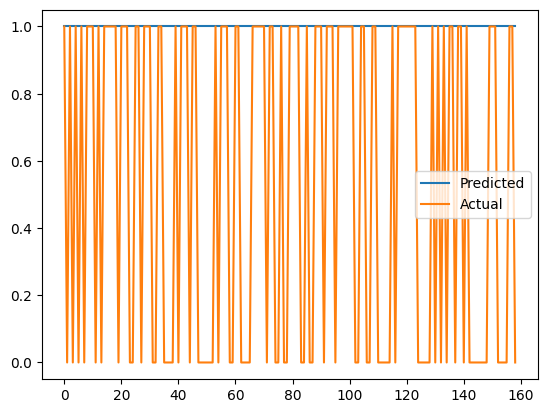

In [22]:
plt.plot(pred[:200], label="Predicted")
plt.plot(y_test_seq[:200], label="Actual")
plt.legend()
plt.show()


## Implement SMOTE for Class Imbalance


In [23]:
from imblearn.over_sampling import SMOTE

# Reshape X_train_seq from 3D to 2D for SMOTE application
X_train_seq_2d = X_train_seq.reshape(X_train_seq.shape[0], -1)

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the reshaped training data
X_train_resampled_2d, y_train_resampled = smote.fit_resample(X_train_seq_2d, y_train_seq)

# Reshape X_train_resampled_2d back to its original 3D LSTM input shape
X_train_resampled = X_train_resampled_2d.reshape(X_train_resampled_2d.shape[0], timesteps, X_train_seq.shape[2])

print(f"[+] Original X_train_seq shape: {X_train_seq.shape}")
print(f"[+] Original y_train_seq shape: {y_train_seq.shape}")
print(f"[+] Resampled X_train_resampled shape: {X_train_resampled.shape}")
print(f"[+] Resampled y_train_resampled shape: {y_train_resampled.shape}")
print(f"[+] Class distribution after SMOTE: {pd.Series(y_train_resampled).value_counts()}")

[+] Original X_train_seq shape: (848, 30, 800)
[+] Original y_train_seq shape: (848,)
[+] Resampled X_train_resampled shape: (894, 30, 800)
[+] Resampled y_train_resampled shape: (894,)
[+] Class distribution after SMOTE: 0    447
1    447
Name: count, dtype: int64


In [24]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(timesteps, X_train_resampled.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1) # Removed sigmoid activation
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

# Class weights are not needed after SMOTE as the dataset is balanced
print(f"[+] Model architecture:")
model.summary()

print("[+] Starting model training with SMOTE-resampled data...")
history_smote = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[es]
)
print("[+] Model training complete.")

[+] Model architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │       475,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,169 (2.01 MB)

 Trainable params: 527,169 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

[+] Starting model training with SMOTE-resampled data...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5199 - loss: 0.7019 - val_accuracy: 0.4620 - val_loss: 0.6908
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.4885 - loss: 0.6920 - val_accuracy: 0.4620 - val_loss: 0.7062
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4744 - loss: 0.6983 - val_accuracy: 0.4620 - val_loss: 0.7006
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.4924 - loss: 0.6994 - val_accuracy: 0.4620 - val_loss: 0.6955
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4848 - loss: 0.6947 - val_accuracy: 0.4620 - val_loss: 0.6993
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5084 - loss: 0.6932 - val_accuracy: 0.4620 - val_loss: 0.6903
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4880 - loss: 0.6958 - val_accuracy: 0.4620 - val_loss: 0.6939
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - a

## Re-evaluate Model Performance


In [25]:
y_pred_logits_smote = model.predict(X_test_seq)
y_pred_binary_smote = (tf.nn.sigmoid(y_pred_logits_smote) > 0.5).numpy().astype(int)

print("[+] Model Performance on Test Set (after SMOTE):")
print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_binary_smote):.4f}")
print(f"Precision: {precision_score(y_test_seq, y_pred_binary_smote):.4f}")
print(f"Recall: {recall_score(y_test_seq, y_pred_binary_smote):.4f}")
print(f"F1 Score: {f1_score(y_test_seq, y_pred_binary_smote):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_seq, y_pred_binary_smote))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
[+] Model Performance on Test Set (after SMOTE):
Accuracy: 0.5346
Precision: 0.5346
Recall: 1.0000
F1 Score: 0.6967
Confusion Matrix:
[[ 0 74]
 [ 0 85]]


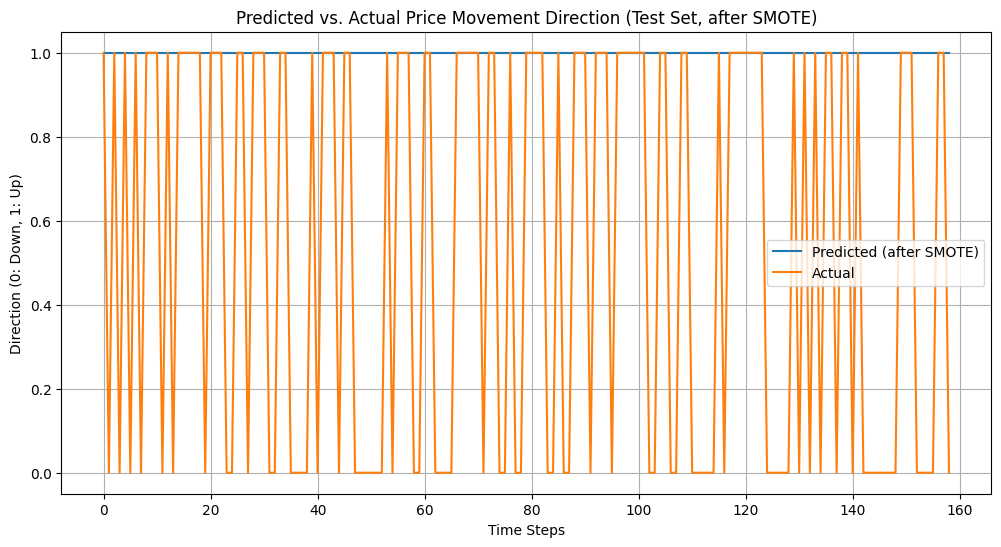

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_pred_binary_smote[:200], label="Predicted (after SMOTE)")
plt.plot(y_test_seq[:200], label="Actual")
plt.title("Predicted vs. Actual Price Movement Direction (Test Set, after SMOTE)")
plt.xlabel("Time Steps")
plt.ylabel("Direction (0: Down, 1: Up)")
plt.legend()
plt.grid(True)
plt.show()